In [1]:
!wget https://github.com/WiraDKP/deep_learning/raw/master/15%20-%20Transfer%20Learning/data.zip

--2023-08-26 10:49:38--  https://github.com/WiraDKP/deep_learning/raw/master/15%20-%20Transfer%20Learning/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WiraDKP/deep_learning/master/15%20-%20Transfer%20Learning/data.zip [following]
--2023-08-26 10:49:38--  https://raw.githubusercontent.com/WiraDKP/deep_learning/master/15%20-%20Transfer%20Learning/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25672319 (24M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]  24.48M  --.-KB/s    in 0.07s   

2023-08-26 10:49:39 (358 MB/s) - ‘data.zip.

In [2]:
!pip install jcopdl==1.1.1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import jcopdl
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
jcopdl.__version__

'1.1.1'

<h2> Datasets & Dataloader </h2>

* Data yang dipakai adalah data panorama
* Case pada data ini adalah klasifikasi multilabel

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [6]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # sesuai dokumentasi
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = MultilabelDataset("/content/data/train_label.csv", "/content/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("/content/data/test_label.csv", "/content/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)


In [7]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

<h2> Arsitektur & Config

Contoh cara pakai Pretrained-Model

In [8]:
from torchvision.models import mobilenet_v2

In [9]:
mnet = mobilenet_v2(pretrained=True)

In [10]:
# freeze

for param in mnet.parameters():
    param.requires_grad = False

In [11]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [12]:
# ganti classifier nya sesuai kasus kita yg punya 5 class dan multilabel case
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
# buat class nya agar lebih rapi

class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [14]:
config = set_config({
    "output_size":len(label2cat),
    "batch_size": bs,
    "crop_size": crop_size
})

<h2> Phase 1 : Adaptation (lr standard + low patience)

<h3> MCOC

In [15]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4976 | Test_cost  = 0.3883 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3531 | Test_cost  = 0.3065 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.3000 | Test_cost  = 0.2836 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2725 | Test_cost  = 0.2636 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2569 | Test_cost  = 0.2438 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2449 | Test_cost  = 0.2377 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2451 | Test_cost  = 0.2285 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2349 | Test_cost  = 0.2267 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2231 | Test_cost  = 0.2293 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2267


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>AssertionError
: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     if w.is_aliv

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2186 | Test_cost  = 0.2233 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2170 | Test_cost  = 0.2184 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2238 | Test_cost  = 0.2138 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2160 | Test_cost  = 0.2218 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2138


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2141 | Test_cost  = 0.2168 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2138
==> Execute Early Stopping at epoch: 14 | Best test_cost: 0.2138
==> Best model is saved at model


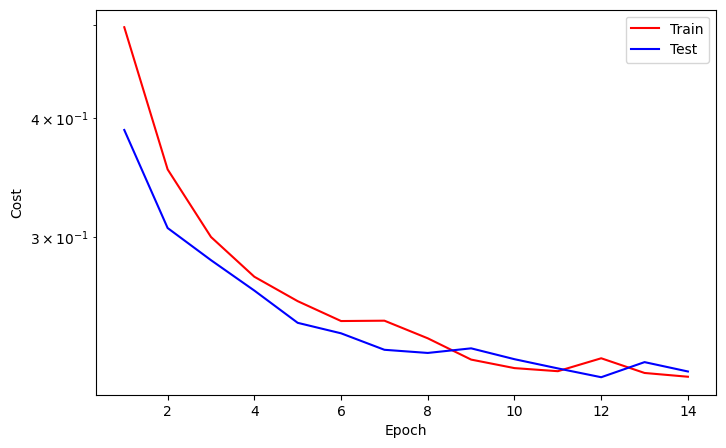

In [17]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> Phase 2 : Fine tuning (lr dikecilin, patience ditambah)

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1990 | Test_cost  = 0.2028 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1784 | Test_cost  = 0.1960 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1698 | Test_cost  = 0.1848 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/pyt

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1624 | Test_cost  = 0.1855 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1848


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1513 | Test_cost  = 0.1799 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1447 | Test_cost  = 0.1764 | 


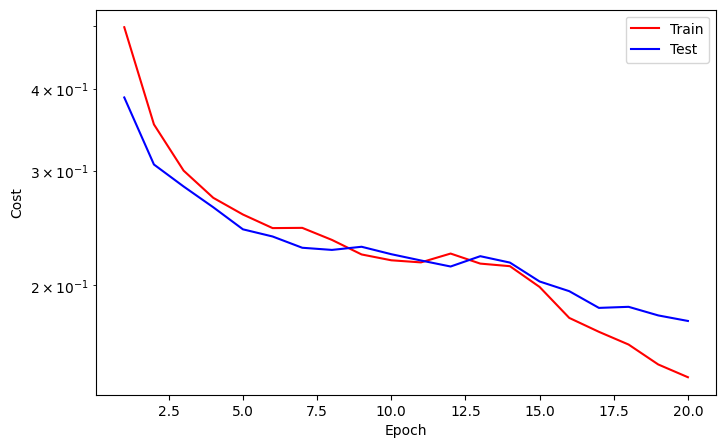

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1370 | Test_cost  = 0.1725 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1387 | Test_cost  = 0.1748 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1725


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1297 | Test_cost  = 0.1712 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/pyth

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1259 | Test_cost  = 0.1751 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1712


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1241 | Test_cost  = 0.1693 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1195 | Test_cost  = 0.1718 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1693


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1189 | Test_cost  = 0.1604 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1119 | Test_cost  = 0.1625 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1604


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.1065 | Test_cost  = 0.1669 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1604


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.1055 | Test_cost  = 0.1618 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1604


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0993 | Test_cost  = 0.1552 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.1004 | Test_cost  = 0.1573 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1552


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.1003 | Test_cost  = 0.1596 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1552


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0946 | Test_cost  = 0.1557 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1552


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0919 | Test_cost  = 0.1551 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a12d8e90430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/u

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0877 | Test_cost  = 0.1526 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0848 | Test_cost  = 0.1557 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0852 | Test_cost  = 0.1595 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0823 | Test_cost  = 0.1605 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0777 | Test_cost  = 0.1589 | 


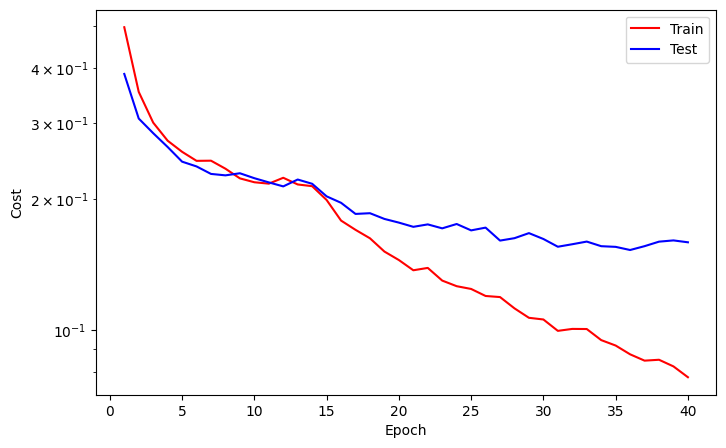

==> EarlyStop patience =  4 | Best test_cost: 0.1526


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0788 | Test_cost  = 0.1564 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1526
==> Execute Early Stopping at epoch: 41 | Best test_cost: 0.1526
==> Best model is saved at model


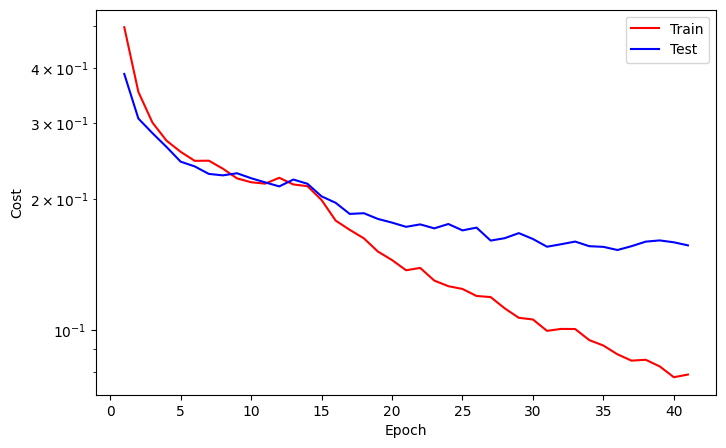

In [18]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

# bisa dibungkus jadi fit method
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> PREDICT

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [24]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1

<h2> Sanity Check

In [25]:
def convert_to_label(x):
    return (label for pred, label in zip(x, label2cat) if pred==1)

# karena kita ingin mengeplotnya
# invers image nya, karena data pipeline kita sebelumnya di normalisasi
# jika tidak maka gambar akan aneh
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485 # dikali standard deviasi + rata-rata
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}\n Pred: {pred}", fontdict=font);
    ax.axis('off');